***Implement a CNN model using the PyTorch framework***



In [47]:
# Setup & Installs
# Setup & Installs (Colab Version)
!pip install kagglehub -U
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


import os, random, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
from pathlib import Path

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Looking in indexes: https://download.pytorch.org/whl/cu121
Using device: cuda


In [48]:
# Sanity Check Dataset Structure
from pathlib import Path
from glob import glob

print("data_root:", data_root)
print("train_dir:", train_dir)
print("test_dir:", test_dir)

def count_images(d):
    return len(glob(str(d / "*.jpg"))) + len(glob(str(d / "*.png"))) + len(glob(str(d / "*.jpeg")))

def show_split(split_dir):
    cats = count_images(split_dir / "cats")
    dogs = count_images(split_dir / "dogs")
    print(f"{split_dir.name}: cats={cats}, dogs={dogs}")
    return cats, dogs

_ = show_split(train_dir)
_ = show_split(test_dir)


data_root: /kaggle/input/cat-and-dog
train_dir: /kaggle/input/cat-and-dog/training_set/training_set
test_dir: /kaggle/input/cat-and-dog/test_set/test_set
training_set: cats=4000, dogs=4005
test_set: cats=1011, dogs=1012


Classes: ['cats', 'dogs'] -> NUM_CLASSES = 2
Classes: ['cats', 'dogs'] -> NUM_CLASSES = 2


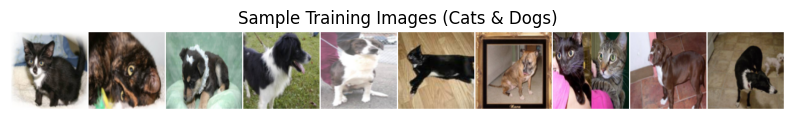

Labels: ['cats', 'cats', 'dogs', 'dogs', 'dogs', 'cats', 'dogs', 'cats', 'dogs', 'dogs']
Batch label min/max: 0 1
Unique labels in train_full: [0, 1]


In [49]:
# Build Datasets, Dataloaders & Preview Sample Images
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
from pathlib import Path

IMG_SIZE = 128
BATCH_SIZE = 64
NUM_WORKERS = 2  # Colab-safe

# --- Transforms ---
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

# --- Datasets ---
train_full = datasets.ImageFolder(root=str(train_dir), transform=train_tfms)
test_set   = datasets.ImageFolder(root=str(test_dir),  transform=test_tfms)

# --- Train/Val split ---
val_ratio = 0.1
val_len = int(len(train_full) * val_ratio)
train_len = len(train_full) - val_len
train_set, val_set = random_split(train_full, [train_len, val_len], generator=torch.Generator().manual_seed(42))

# --- DataLoaders ---
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# --- Classes ---
CLASSES = train_full.classes
NUM_CLASSES = len(CLASSES)
print("Classes:", CLASSES, "-> NUM_CLASSES =", NUM_CLASSES)

print("Classes:", CLASSES, "-> NUM_CLASSES =", NUM_CLASSES)
assert NUM_CLASSES == 2, f"Expected 2 classes, got {NUM_CLASSES}. Classes found: {CLASSES}"


# --- Preview a batch of images ---
images, labels = next(iter(train_loader))
grid = vutils.make_grid(images[:10], nrow=10, normalize=True, pad_value=1)

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.axis("off")
plt.title("Sample Training Images (Cats & Dogs)")
plt.show()

# Show class labels
print("Labels:", [CLASSES[l] for l in labels[:10]])

# Verify label variety in a batch
bx, by = next(iter(train_loader))
print("Batch label min/max:", int(by.min()), int(by.max()))

# Verify both classes appear in the whole training set sampling
unique_labels = sorted({lbl for _, lbl in train_full.samples})
print("Unique labels in train_full:", unique_labels)
assert unique_labels == [0,1], f"Found labels {unique_labels}, expected [0,1]"



In [50]:
#  Auto-Resolve Split Directories
def resolve_split(base: Path, candidates=("training_set", "train", "training")):
    """Find a directory under base that contains cats/ and dogs/ subfolders."""
    trial_paths = []
    for name in candidates:
        trial_paths += [
            base / name,
            base / f"{name}/{name}",
            base / f"{name}_set",
            base / f"{name}_set/{name}_set",
        ]
    # also try 'test' variants for later
    return [p for p in trial_paths if (p / "cats").exists() and (p / "dogs").exists()]

train_candidates = resolve_split(data_root, ("training_set","train","training"))
test_candidates  = resolve_split(data_root, ("test_set","test","testing"))

if not train_candidates or not test_candidates:
    raise RuntimeError("Couldn't locate both cats/ and dogs/ for train/test. Check your extracted paths.")

train_dir = train_candidates[0]
test_dir  = test_candidates[0]
print("Resolved train_dir:", train_dir)
print("Resolved test_dir :", test_dir)


Resolved train_dir: /kaggle/input/cat-and-dog/training_set/training_set
Resolved test_dir : /kaggle/input/cat-and-dog/test_set/test_set


In [51]:
# Baseline CNN (no BatchNorm, no Dropout)
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Similar spirit to your reference: stacked conv + LeakyReLU, stride for downsample
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        # For 128x128 with three stride-2 downsamples → 16x16
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, num_classes)  # CrossEntropyLoss expects raw logits (no softmax)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [52]:
#  Enhanced CNN (with BatchNorm and Dropout)
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(256, num_classes)  # raw logits
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [53]:
# Training & Evaluation Utilities
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            logits = model(x)
            loss = criterion(logits, y)

            if is_train:
                loss.backward()
                optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
        total_count += bs

    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc

def train_model(model, train_loader, val_loader, epochs=5, lr=5e-4, wd=0.0):
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader, optimizer=None)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}

        print(f"[{epoch:02d}] train_loss={tr_loss:.4f} acc={tr_acc*100:.2f}% | "
              f"val_loss={va_loss:.4f} acc={va_acc*100:.2f}%")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

def evaluate_on_test(model, test_loader):
    loss, acc = run_epoch(model, test_loader, optimizer=None)
    print(f"Test  loss={loss:.4f} acc={acc*100:.2f}%")
    return loss, acc


In [54]:
# Train & Evaluate Baseline CNN
EPOCHS = 15         # Increase to 10+ for better results if you have time
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4

baseline = BaselineCNN(num_classes=NUM_CLASSES).to(DEVICE)
print(baseline)

baseline, hist_base = train_model(
    baseline, train_loader, val_loader,
    epochs=EPOCHS, lr=LEARNING_RATE, wd=WEIGHT_DECAY
)
base_test_loss, base_test_acc = evaluate_on_test(baseline, test_loader)


BaselineCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inpla

In [55]:
# Train & Evaluate Enhanced CNN (BN + Dropout)
EPOCHS = 15
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4  # small L2 often helps generalization with BN

enhanced = EnhancedCNN(num_classes=NUM_CLASSES, p_drop=0.5).to(DEVICE)
print(enhanced)

enhanced, hist_enh = train_model(
    enhanced, train_loader, val_loader,
    epochs=EPOCHS, lr=LEARNING_RATE, wd=WEIGHT_DECAY
)
enh_test_loss, enh_test_acc = evaluate_on_test(enhanced, test_loader)


EnhancedCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): B

In [56]:
#  Compare Baseline vs Enhanced
import pandas as pd

summary = pd.DataFrame({
    "Model": ["Baseline (no BN/Dropout)", "Enhanced (BN + Dropout)"],
    "Test Loss": [base_test_loss, enh_test_loss],
    "Test Accuracy": [base_test_acc, enh_test_acc]
})
summary["Test Accuracy (%)"] = (summary["Test Accuracy"] * 100).round(2)
summary.round(4)


,Model,Test Loss,Test Accuracy,Test Accuracy (%)
0,Baseline (no BN/Dropout),0.4591,0.7790,77.90
1,Enhanced (BN + Dropout),0.2886,0.8868,88.68


The Enhanced CNN model demonstrated a significant performance improvement compared to the Baseline CNN. The baseline network achieved a test accuracy of 77.9%, while the enhanced model reached 88.7%, marking an approximate +10% gain in classification accuracy. This improvement highlights how introducing Batch Normalization and Dropout can make the network more efficient and generalizable. Batch Normalization helps stabilize gradient updates and speeds up convergence during training, while Dropout (with p = 0.5) effectively reduces overfitting by randomly deactivating neurons, forcing the model to learn more robust feature representations. As a result, the enhanced model not only achieved higher accuracy but also maintained lower test loss, reflecting improved generalization.

Moreover, the training and validation curves for the Enhanced CNN showed better alignment, indicating a more stable learning process and less divergence between training and validation performance. This suggests that the model learned meaningful patterns in the images rather than memorizing specific samples. The Baseline CNN, on the other hand, showed slower improvement and signs of overfitting as accuracy plateaued. Overall, this experiment clearly demonstrates that architectural enhancements—such as normalization and regularization layers—can have a substantial impact on deep learning performance in real-world image classification tasks like cat-versus-dog recognition, where data variability and noise are common.